In [2]:
import yt
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

yt.set_log_level("error")
mpl.rcParams["font.family"] = "serif"
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams["text.usetex"] = True
mpl.rcParams["lines.linewidth"] = 1
mpl.rcParams["lines.markersize"] = 3.5
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["legend.frameon"] = False
mpl.rcParams["legend.fontsize"] = "small"
mpl.rcParams["axes.titlesize"] = "medium"

/home/bendp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def format_axes(ax, xlab):
    ax[0,0].set_xlabel(xlab)
    ax[0,1].set_xlabel(xlab)
    ax[1,0].set_xlabel(xlab)
    ax[1,1].set_xlabel(xlab)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    ax[0,0].set_ylabel("Density, $\\rho$")
    ax[0,1].set_ylabel("Velocity, $v$")
    ax[1,0].set_ylabel("Pressure, $p$")
    ax[1,1].set_ylabel("Specific internal energy, $\epsilon$")

def get_conservative_field_names(dim, has_imex_pressure=False):
    fields = ["x", "density", "mom_x", "energy"]
    if has_imex_pressure: fields.append("IMEX_pressure")
    if dim >= 2:
        fields.append("y")
        fields.append("mom_y")
    if dim >= 3:
        fields.append("z")
        fields.append("mom_z")
    return fields

def get_ray(adiabatic, epsilon, rot, dim, ds, has_imex_pressure=False):
    rot = np.deg2rad(rot)
    fields = get_conservative_field_names(dim, has_imex_pressure)
    if dim == 1:
        ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0]).to_dataframe(fields)
    else:
        ray = ds.ray([0, 0.5 - 0.5*np.tan(rot), 0], [1, 0.5 + 0.5*np.tan(rot), 0]).to_dataframe(fields)
    size = np.array(ray["x"]).size
    if (dim < 2):
        ray["mom_y"] = np.zeros(size)
        ray["y"] = np.zeros(size)
    if (dim < 3):
       ray["mom_z"] = np.zeros(size)
       ray["z"] = np.zeros(size)

    if (dim == 1):
        ray["d"] = ray["x"]
    else:
        ray["d"] = (ray["x"] - 0.5)*np.cos(rot) + (ray["y"] - 0.5)*np.sin(rot) + 0.5
    ray["mom"] = np.sqrt(ray["mom_x"] * ray["mom_x"] + ray["mom_y"] * ray["mom_y"] + ray["mom_z"] * ray["mom_z"])
    ray["vel"] = ray["mom"] / ray["density"] * np.sign(ray["mom_x"])
    ray["int_energy"] = (ray["energy"] - 0.5 * epsilon * ray["mom"] * ray["mom"] / ray["density"]) / ray["density"]
    ray["pressure"] = (adiabatic - 1) * ray["density"] * ray["int_energy"]
    return ray


def plot_four(ray, ax, fmt, label, plot_imex_pressure=False, **kwargs):    
    ax[0,0].plot(ray["d"],ray["density"],fmt,label=label, **kwargs)
    ax[0,1].plot(ray["d"],ray["vel"],fmt,label=label, **kwargs)
    # ax[0,1].plot(ray["d"],ray["mom_x"],fmt,label=label, **kwargs)
    if not plot_imex_pressure:
        ax[1,0].plot(ray["d"],ray["pressure"],fmt,label=label, **kwargs)
    else:
        ax[1,0].plot(ray["d"],ray["IMEX_pressure"],fmt,label=label, **kwargs)
    ax[1,1].plot(ray["d"],ray["int_energy"],fmt,label=label, **kwargs)

# Takes an approximate solution and an exact solution with different resolutions and return an array of errors
def get_error(approx_soln, approx_x, exact_soln, exact_x):
    assert(approx_soln.size == approx_x.size)
    assert(exact_soln.size == exact_x.size)
    exact_interp = np.interp(approx_x, exact_x, exact_soln, np.NAN, np.NAN)
    return approx_soln - exact_interp

def get_dx(soln):
    return soln["x"][1] - soln["x"][0]

def error_norm(error, dx, ord):
    if (ord == np.inf):
        return np.abs(error).max()
    return np.power(np.power(np.abs(error), ord).sum() * dx.prod(), 1/ord)

def add_inset(x1,x2,y1,y2,pos,ax):
    axins = ax.inset_axes(
            pos,
            xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    lines = ax.lines
    for line in lines:
        axins.plot(line.get_xdata(), line.get_ydata(), c=line.get_color(), marker=line.get_marker(), markersize=line.get_markersize(), linestyle=line.get_linestyle(), fillstyle=line.get_fillstyle(), markeredgewidth=line.get_markeredgewidth())
    ax.indicate_inset_zoom(axins, edgecolor="black")

# Live plots
## 1D tests

['build/Exec/RiemannProblem/output/HLLC/test1scaled/0100/plt00068', 'build/Exec/RiemannProblem/output/HLLC/test1scaled/0200/plt00138', 'build/Exec/RiemannProblem/output/HLLC/test1scaled/0400/plt00276']


/tmp/ipykernel_5452/1626702505.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


['build/Exec/RiemannProblem/output/PEEK-SA111/test1scaled/0100/plt00054', 'build/Exec/RiemannProblem/output/PEEK-SA111/test1scaled/0200/plt00106', 'build/Exec/RiemannProblem/output/PEEK-SA111/test1scaled/0400/plt00214']


/tmp/ipykernel_5452/1626702505.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


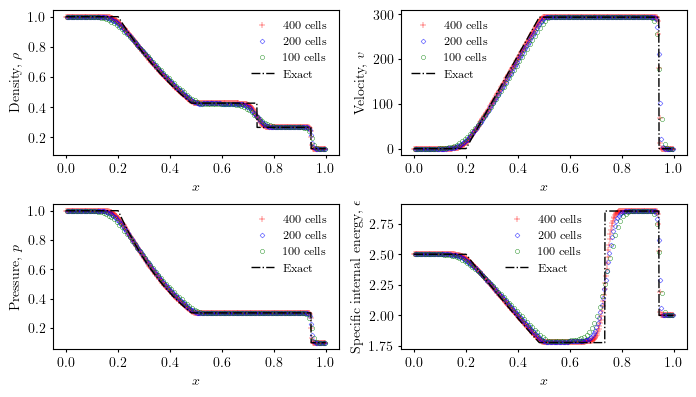

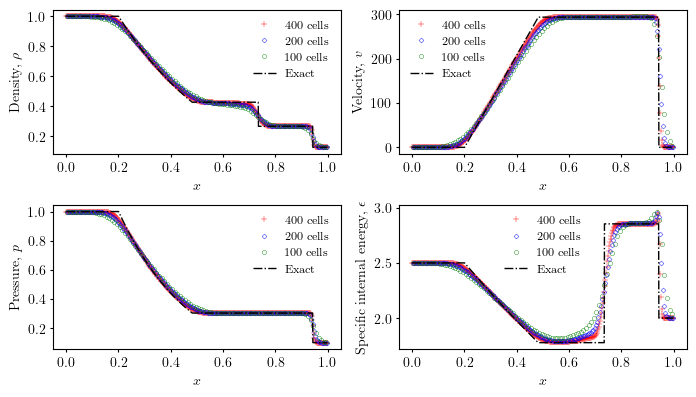

In [4]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/FI-SP111/lax/*",#0
               "build/Exec/RiemannProblem/output/PESK-SP111/lax/*", #1
               "build/Exec/RiemannProblem/output/HLLC/test1/*", #2
               "build/Exec/RiemannProblem/output/FI-SP111/test1/*", #3
               "build/Exec/RiemannProblem/output/PESK-SP111/test1/*", #4
               "build/Exec/RiemannProblem/output/PEEK-SP111/test1/*", #5
               "build/Exec/RiemannProblem/output/HLLC/test2/*", #6
               "build/Exec/RiemannProblem/output/FI-SP111/test2/*", #7
               "build/Exec/RiemannProblem/output/PESK-SP111/test2/*", #8
               "build/Exec/RiemannProblem/output/PEEK-SP111/test2/*", #9
               "build/Exec/RiemannProblem/output/HLLC/test3/*", #10
               "build/Exec/RiemannProblem/output/FI-SP111/test3/*", #11
               "build/Exec/RiemannProblem/output/PESK-SP111/test3/*", #12
               "build/Exec/RiemannProblem/output/PEEK-SP111/test3/*", #13
               "build/Exec/RiemannProblem/output/HLLC/incshocks/*", #14
               "build/Exec/RiemannProblem/output/FI-SP111/incshocks/*", #15
               "build/Exec/RiemannProblem/output/PESK-SP111/incshocks/*", #16
               "build/Exec/RiemannProblem/output/PEEK-SP111/incshocks/*", #17
               "build/Exec/RiemannProblem/output/EEEK-SP111/incshocks/*", #18
               "build/Exec/SinProblem/output/HLLC/eps1/*", # 19
               "build/Exec/SinProblem/output/FI-SP111/eps1/*", # 20
               "build/Exec/SinProblem/output/PESK-SP111/eps1/*", # 21
               "build/Exec/SinProblem/output/PEEK-SP111/eps1/*", # 22
               "build/Exec/RiemannProblem/output/HLLC/test1scaled/*", # 23
               "build/Exec/RiemannProblem/output/PEEK-SP111/test1scaled/*", # 24
               "build/Exec/SinProblem/output/HLLC/eps1e-5/*" # 25
               ]

# DIRECTORIES = ["build_gpu/Exec/RiemannProblem/output/test1/*",
#                "build_gpu/Exec/RiemannProblem/output/test2/*",
#                "build_gpu/Exec/RiemannProblem/output/test3/*",
#                "build_gpu/Exec/RiemannProblem/output/test4/*",
#                "build_gpu/Exec/RiemannProblem/output/test5/*",
#                "build_gpu/Exec/RiemannProblem/output/test6/*",
#                "build_gpu/Exec/SinProblem/output/*",
#                "build_gpu/Exec/RiemannProblem2D/output/test1/35deg/*"]

EXACT_SOLN_EXISTS = [True] * len(DIRECTORIES)
COMPUTE_CONVERGENCE = [False] * len(DIRECTORIES)
NAMES = ["lax-FISP111", "lax-PESKSP111", "test1-HLLC", "test1-FISP111", "test1-PESKSP111",
         "test1-PEEKSP111", "test2-HLLC", "test2-FISP111", "test2-PESKSP111", "test2-PEEKSP111",
         "test3-HLLC", "test3-FISP111", "test3-PESKSP111", "test3-PEEKSP111",
         "incshocks-HLLC", "incshocks-FISP111", "incshocks-PESKSP111", "incshocks-PEEKSP111", "incshocks-EEEKSP111",
         "sinprob-eps1-HLLC", "sinprob-eps1-FISP111", "sinprob-eps1-PESKSP111", "sinprob-eps1-PEEKSP111",
         "test1scaled-HLLC", "test1scaled-PEEKSP111",
         "sinprob-eps1e-5-HLLC"]
ADIABATICS = [1.4] * len(DIRECTORIES)
EPSILONS = [1] * 23 + [1e-5] * 3
DIMS = [1] * len(DIRECTORIES)
ROTS = [0] * len(DIRECTORIES)
# DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
# ROTS = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

# tests_to_plot = [0,2,3,4,5,6,7]
# tests_to_plot = list(range(26, len(DIRECTORIES)))
tests_to_plot = [23,24]

for i in tests_to_plot:
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt[!E]*"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    print(SUBRUN_FINAL_OUTPUTS)
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = ADIABATICS[i]
    epsilon = EPSILONS[i]
    dim = DIMS[i]
    rot = ROTS[i]
    fig, ax = plt.subplots(2, 2, figsize=(7,4))

    # fig.suptitle(NAMES[i])

    num_solns = {}

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"{ds.domain_dimensions[0]} cells"

        # ray
        ray = get_ray(adiabatic, epsilon, rot, dim, ds, True)
        plot_four(ray,ax,res_fmts[ifile],label,plot_imex_pressure=False,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        if COMPUTE_CONVERGENCE[i]:
            num_solns[ds.domain_dimensions[0]] = ray

    # plot exact solution
    if (EXACT_SOLN_EXISTS[i]):
        label = "Exact"
        ds = yt.load(EXACT_SOLUTION)
        exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
        plot_four(exact_ray,ax,exact_fmt,label)

    if (COMPUTE_CONVERGENCE[i]):
        assert(EXACT_SOLN_EXISTS[i])
        print(NAMES[i] + " convergence:")

        df = pd.DataFrame(columns=["dx", "Density L1", "Density L2", "Density Linf"])
        for res in sorted(num_solns.keys()):
            soln = num_solns[res]
            soln["error_density"] = get_error(soln["density"], soln["x"], exact_ray["density"], exact_ray["x"])
            dx = get_dx(soln)
            ndx = np.array([dx])
            L1 = error_norm(soln["error_density"],ndx,1)
            L2 = error_norm(soln["error_density"],ndx,2)
            Linf = error_norm(soln["error_density"],ndx,np.inf)
            df.loc[res] = [dx, L1, L2, Linf]
        df.insert(2, "L1 order", np.log(df["Density L1"] / df["Density L1"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(4, "L2 order", np.log(df["Density L2"] / df["Density L2"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        df.insert(6, "Linf order", np.log(df["Density Linf"] / df["Density Linf"].iat[0]) / np.log(df["dx"] / df["dx"].iat[0]))
        print(df)

    # make plots pretty
    xlab = "$x$"
    format_axes(ax, xlab)

    if i in [0,1]: # lax test
        add_inset(0.68,0.87,1.25,1.34, [0.275,0.1,0.35,0.4], ax[0,0])
        add_inset(0.7,0.87,4,6,[0.33,0.05,0.3,0.4], ax[1,1])

    if i in [2,3,4,5]:  #toro test 1
        ax[0,1].legend(loc=[0.4,0.05])
        # inset axes....
        # add_inset(0.7,0.76,0.2,0.5, [0.05, 0.05, 0.4, 0.4], ax[0,0])
        # add_inset(0.68, 0.78, 1.7, 3, [0.05, 0.05, 0.4, 0.4], ax[1,1])
        # add_inset(0.4,0.55,0.85,0.95,[0.05,0.25,0.4,0.4],ax[0,1])
    
    if i in [6,7,8,9]:  #toro test 2
        # inset axes....
        add_inset(0.4,0.6,0,0.05,[0.55,0.05,0.4,0.4],ax[0,0])
        add_inset(0.4,0.6,-0.2,0.2,[0.55,0.05,0.4,0.4],ax[0,1])
    
    if i in [10,11,12,13]: # Toro test 3
        add_inset(0.71, 0.8, 3, 6.5, [0.4, 0.2, 0.2, 0.6], ax[0,0])
        add_inset(0.72, 0.8, 400, 500, [0.05, 0.05, 0.3, 0.4], ax[1,0])
        add_inset(0.72, 0.82, -50, 500, [0.4, 0.05, 0.2, 0.4], ax[1,1])
    
    # if i == 4:
    #     add_inset(0.52,0.54,ax[0,0].get_ylim()[0],1.3,[0.05,0.05,0.4,0.4],ax[0,0])

    fig.tight_layout(pad=0.8)
    # fig.savefig(f"outputs/{NAMES[i]}.pdf", dpi=300)
    fig.show()

## CFL Test

Cannot find results with pattern build/Exec/RiemannProblem/output/FI-SA111/CFLtest/*
Cannot find results with pattern build/Exec/RiemannProblem/output/PESK-SA111/CFLtest/*
Cannot find results with pattern build/Exec/RiemannProblem/output/EESK-SA111/CFLtest/*
Cannot find results with pattern build/Exec/RiemannProblem/output/PEEK-SA111/CFLtest/*
Cannot find results with pattern build/Exec/RiemannProblem/output/EEEK-SA111/CFLtest/*


/tmp/ipykernel_111841/2135480026.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


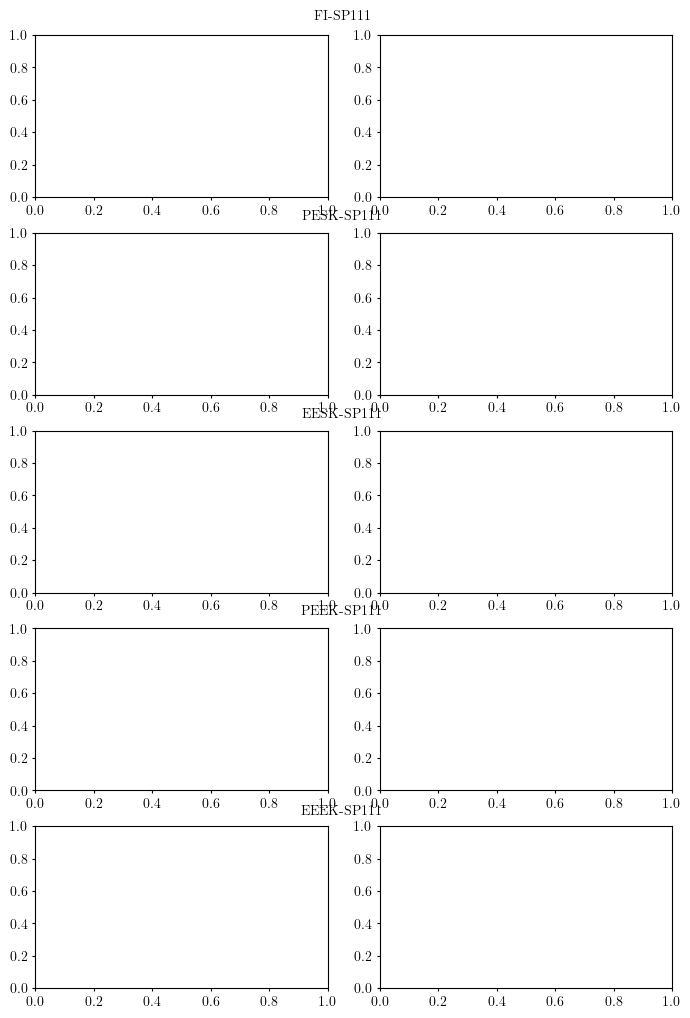

In [4]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/FI-SP111/CFLtest/*",
               "build/Exec/RiemannProblem/output/PESK-SP111/CFLtest/*",
               "build/Exec/RiemannProblem/output/EESK-SP111/CFLtest/*",
               "build/Exec/RiemannProblem/output/PEEK-SP111/CFLtest/*",
               "build/Exec/RiemannProblem/output/EEEK-SP111/CFLtest/*"]

NAMES = ["FI-SP111", "PESK-SP111", "EESK-SP111", "PEEK-SP111", "EEEK-SP111"]

CFLs = [0.5, 0.7, 0.9]

#
# PESK pressure-enthalpy split-kinetic
# PEEK pressure-enthalpy explicit-kinetic
# EESK explicit-enthalpy split-kinetic
# EEEK explicit-enthalpy explicit-kinetic
# CESK conservative-enthalpy split kinetic
# CEEK conservative-enthalpy explicit-kinetic
#


exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

fig, ax = plt.subplots(5, 2, figsize=(7,10))

for i in range(len(DIRECTORIES)):
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt?????"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = 1.4
    epsilon = 1
    dim = 1
    rot = 0

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"CFL = {CFLs[ifile]}"
        # print(plotfile)
        # print(CFLs[ifile])

        # ray
        ray = get_ray(adiabatic, epsilon, rot, dim, ds)
        # plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        ax[i,0].plot(ray["x"], ray["density"],res_fmts[ifile],label=label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        ax[i,1].plot(ray["x"], ray["int_energy"],res_fmts[ifile],label=label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)

    label = "Exact"
    ds = yt.load(EXACT_SOLUTION)
    exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
    # plot_four(exact_ray,ax,exact_fmt,label)
    ax[i,0].plot(exact_ray["x"], exact_ray["density"],exact_fmt,label=label)
    ax[i,1].plot(exact_ray["x"], exact_ray["int_energy"],exact_fmt,label=label)

    add_inset(0.68,0.87,1.25,1.34, [0.275,0.1,0.35,0.4], ax[i,0])
    add_inset(0.69,0.87,4,6,[0.37,0.05,0.3,0.4], ax[i,1])

    # make plots pretty
    ax[i,0].set_xlabel("$x$")
    ax[i,1].set_xlabel("$x$")
    ax[i,0].set_ylabel("Density, $\\rho$")
    ax[i,1].set_ylabel("Specific internal energy, $\\epsilon$")
    ax[i,0].legend()
    ax[i,1].legend()

names_ys = [1, 0.8, 0.602, 0.405, 0.205]
for i in range(len(NAMES)):
    fig.text(0.5, names_ys[i], NAMES[i], horizontalalignment="center")

fig.tight_layout(pad=0.8)
# fig.savefig(f"outputs/cfl_test.pdf", bbox_inches="tight")
fig.show()

## Test 3

/tmp/ipykernel_1102/80280363.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


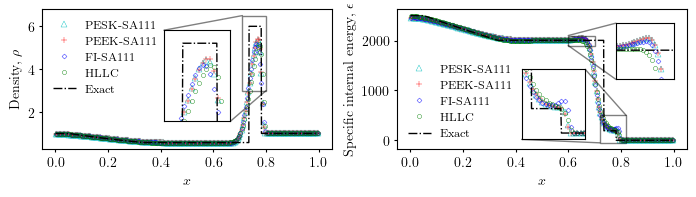

In [48]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/HLLC/test3/200/plt?????",
               "build/Exec/RiemannProblem/output/FI-SP111/test3/200/plt?????",
               "build/Exec/RiemannProblem/output/PEEK-SP111/test3/200/plt?????",
               "build/Exec/RiemannProblem/output/PESK-SP111/test3/200/plt?????"]

EXACT_SOLUTION = "build/Exec/RiemannProblem/output/HLLC/test3/200/pltEXACT_SOLN"

NAMES = ["HLLC", "FI-SP111", "PEEK-SP111", "PESK-SP111"]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

fig, ax = plt.subplots(1, 2, figsize=(7,2))

for i in range(len(DIRECTORIES)-1,-1,-1):
    PLOTFILES = glob.glob(DIRECTORIES[i])
    if (len(PLOTFILES) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    ds = yt.load(sorted(PLOTFILES)[-1])
    label = NAMES[i]
    
    adiabatic = 1.4
    epsilon = 1
    rot = 0
    dim = 1
    # ray
    ray = get_ray(adiabatic, epsilon, rot, dim, ds)
    # plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
    ax[0].plot(ray["x"], ray["density"],res_fmts[i],label=label,markersize = marker_sizes[i], fillstyle="none", markeredgewidth=0.3)
    ax[1].plot(ray["x"], ray["int_energy"],res_fmts[i],label=label,markersize = marker_sizes[i], fillstyle="none", markeredgewidth=0.3)

ds = yt.load(EXACT_SOLUTION)
exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
# plot_four(exact_ray,ax,exact_fmt,label)
ax[0].plot(exact_ray["x"], exact_ray["density"],exact_fmt,label="Exact")
ax[1].plot(exact_ray["x"], exact_ray["int_energy"],exact_fmt,label="Exact")

# make plots pretty
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")
ax[0].set_ylabel("Density, $\\rho$")
ax[1].set_ylabel("Specific internal energy, $\\epsilon$")
ax[0].legend()
ax[1].legend()

add_inset(0.71, 0.8, 3, 6.5, [0.42, 0.2, 0.23, 0.65], ax[0])
add_inset(0.72, 0.82, -50, 500, [0.43, 0.07, 0.22, 0.5], ax[1])
add_inset(0.6, 0.7, 1900, 2100, [0.755, 0.5, 0.2, 0.4], ax[1])

fig.tight_layout(pad=0.8)
# fig.savefig(f"outputs/test3.pdf", bbox_inches="tight")
fig.show()

    

## Incident shocks test

/tmp/ipykernel_1102/537081078.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


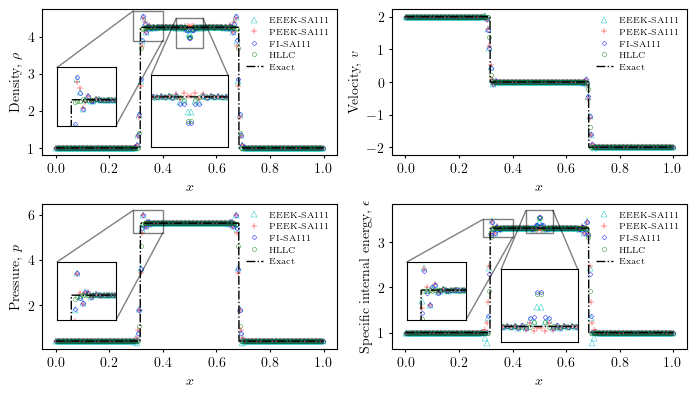

In [93]:
DIRECTORIES = ["build/Exec/RiemannProblem/output/HLLC/incshocks/200/plt?????",
               "build/Exec/RiemannProblem/output/FI-SP111/incshocks/200/plt?????",
            #    "build/Exec/RiemannProblem/output/PESK-SP111/incshocks/200/plt?????",
               "build/Exec/RiemannProblem/output/PEEK-SP111/incshocks/200/plt?????",
               "build/Exec/RiemannProblem/output/EEEK-SP111/incshocks/200/plt?????"]

EXACT_SOLUTION = "build/Exec/RiemannProblem/output/HLLC/incshocks/200/pltEXACT_SOLN"

NAMES = ["HLLC",
         "FI-SP111",
         "PEEK-SP111",
        #  "PESK-SP111",
         "EEEK-SP111"]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

fig, ax = plt.subplots(2, 2, figsize=(7,4))

for i in range(len(DIRECTORIES)-1,-1,-1):
    PLOTFILES = glob.glob(DIRECTORIES[i])
    if (len(PLOTFILES) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    ds = yt.load(sorted(PLOTFILES)[-1])
    label = NAMES[i]
    
    adiabatic = 1.4
    epsilon = 1
    rot = 0
    dim = 1
    # ray
    ray = get_ray(adiabatic, epsilon, rot, dim, ds)
    plot_four(ray,ax,res_fmts[i],label,markersize = marker_sizes[i], fillstyle="none", markeredgewidth=0.3)
    # ax[0].plot(ray["x"], ray["density"],res_fmts[i],label=label,markersize = marker_sizes[i], fillstyle="none", markeredgewidth=0.3)
    # ax[1].plot(ray["x"], ray["int_energy"],res_fmts[i],label=label,markersize = marker_sizes[i], fillstyle="none", markeredgewidth=0.3)

ds = yt.load(EXACT_SOLUTION)
exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
plot_four(exact_ray,ax,exact_fmt,"Exact")
# ax[0].plot(exact_ray["x"], exact_ray["density"],exact_fmt,label="Exact")
# ax[1].plot(exact_ray["x"], exact_ray["int_energy"],exact_fmt,label="Exact")

# make plots pretty
format_axes(ax, "$x$")
# ax[0].set_xlabel("$x$")
# ax[1].set_xlabel("$x$")
# ax[0].set_ylabel("Density, $\\rho$")
# ax[1].set_ylabel("Specific internal energy, $\\epsilon$")
# ax[0].legend()
# ax[1].legend()
ax[0,0].legend(fontsize=6)
ax[1,0].legend(fontsize=6)
ax[1,1].legend(fontsize=6)
ax[0,1].legend(fontsize=6)

add_inset(0.45,0.55,3.7,4.5,[0.37,0.05,0.26,0.5],ax[0,0])
add_inset(0.45,0.55,3.2,3.7,[0.37,0.05,0.26,0.5],ax[1,1])
add_inset(0.29,0.4,3.9,4.7,[0.05,0.2,0.2,0.4],ax[0,0])
add_inset(0.29,0.4,3.1,3.5,[0.05,0.2,0.2,0.4],ax[1,1])
add_inset(0.29,0.4,5.2,6.2,[0.05,0.2,0.2,0.4],ax[1,0])

fig.tight_layout(pad=0.8)
# fig.savefig(f"outputs/incshocks.pdf", bbox_inches="tight")
fig.show()

    

# Convergence

In [29]:
"""
Takes a yt box/region/data container and figures out the dimension of the problem
"""
def get_dim(data):
    assert(data.shape[0] > 1)
    if data.shape[1] == 1:
        assert(data.shape[2] == 1)
        return 1
    if data.shape[2] == 1:
        return 2
    return 3

"""
Takes a dataframe from and adds the primitive variables in
"""
def compute_primitives(data, dim, adiabatic):
    shape = data["x"].shape
    if dim < 2:
        data["y"] = np.zeros(shape)
        data["mom_y"] = np.zeros(shape)
    if dim < 3:
        data["z"] = np.zeros(shape)
        data["mom_z"] = np.zeros(shape)
    data["u"] = data["mom_x"] / data["density"]
    data["v"] = data["mom_y"] / data["density"]
    data["w"] = data["mom_z"] / data["density"]
    data["u_sq"] = data["u"] * data["u"] + data["v"] * data["v"] + data["w"] * data["w"]
    data["int_energy"] = (data["energy"] - 0.5 * data["density"] * data["u_sq"]) / data["density"]
    data["pressure"] = (adiabatic - 1) * (data["energy"] - 0.5 * data["density"] * data["u_sq"])

"""
Takes a yt data object and converts it to a DataFrame.
The fact I have to write this myself is very annoying, but the
to_dataframe() method provided by YT doesn't work for data in >1D...
"""
def to_dataframe(data):
    dim = get_dim(data)
    fields = get_conservative_field_names(dim)
    iterables = [range(0, data.shape[0]), range(0, data.shape[1]), range(0, data.shape[2])]
    index = pd.MultiIndex.from_product(iterables, names=["i","j","k"])
    entries = {}
    for field in fields:
        entries[field] = data[field].to_ndarray().flatten()
    return pd.DataFrame(entries, index=index)

"""
Takes the path to a plotfile and returns a DataFrame with primitive variables computed and its dimension
"""
def open_plotfile(plotfile, adiabatic):
    ds = yt.load(plotfile)
    data = ds.covering_grid(level=ds.max_level, left_edge=ds.domain_left_edge,dims=ds.domain_dimensions*ds.relative_refinement(0,ds.max_level))
    dim = get_dim(data)
    data = to_dataframe(data)
    compute_primitives(data, dim, adiabatic)
    return data, dim

"""
Computes the error norms for density, velocity and pressure using the plotfiles
provided and returns them in array form along with the cell spacing:

[N, dx, density L1, density L2, density Linf, u L1, u L2, u Linf, v L1, v L2, v Linf,
 w L1, w L2, w Linf, pressure L1, pressure L2, pressure Linf]
"""
def compute_error_norms(numerical_plotfile, exact_plotfile, adiabatic):
    # Load files
    num_data, dim = open_plotfile(numerical_plotfile, adiabatic)
    exact_data, exact_dim = open_plotfile(exact_plotfile, adiabatic)
    assert(num_data.shape == exact_data.shape)
    assert(dim == exact_dim)

    # Get N
    N = num_data.shape[0]
    # Get dx (remember that the covered grid has constant cell spacing)
    dx = [num_data["x"][1,0,0]-num_data["x"][0,0,0]]
    if (dim >= 2):
        dx.append(num_data["y"][0,1,0]-num_data["y"][0,0,0])
    if (dim == 3):
        dx.append(num_data["z"][0,0,1]-num_data["z"][0,0,0])
    dx = np.array(dx)

    # Now we can start computing errors

    ## The row returned should match:
    ## ["N", "dx", "density L1", "density L2", "density Linf", "u L1", "u L2", "u Linf",
    ##  "v L1", "v L2", "v Linf", "w L1", "w L2", "w Linf",
    ##  "pressure L1", "pressure L2", "pressure Linf"]

    ## Fields to calculate errors for.
    ## Note that even in 1D v and w have been populated with zeros
    fields = ["density", "u", "v", "w", "pressure"]
    ## This is the row we'll add to the dataframe passed to this function
    row = [N, dx[0]]
    for field in fields:
        error = num_data[field] - exact_data[field]
        row.append(error_norm(error, dx, 1))
        row.append(error_norm(error, dx, 2))
        row.append(error_norm(error, dx, np.inf))
    return row

"""
Parameters
----------
test_dir : test case directory with a glob, for instance \"./build/Exec/IsentropicVortex/output/2d/*\"
    where inside that directory is subdirectories \"100\", \"200\", etc
adiabatic : the adiabatic index
exact_soln_plotfile : the name of the plotfile with the exact solution for each test. Should have the
    same resolution as the test itself
"""
def get_convergence_properties(test_dir, adiabatic, exact_soln_plotfile = "pltEXACT_SOLN"):
    SUBRUN_DIRS = sorted(glob.glob(test_dir))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {test_dir}")
        return
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt[!E]*"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTIONS = [SUBRUN_DIR + "/" + exact_soln_plotfile for SUBRUN_DIR in SUBRUN_DIRS]
    error_norms = []
    for i in range(len(SUBRUN_FINAL_OUTPUTS)):
        error_norms.append(compute_error_norms(SUBRUN_FINAL_OUTPUTS[i], EXACT_SOLUTIONS[i], adiabatic))
    df = pd.DataFrame(columns=["N", "dx", "density L1", "density L2", "density Linf",
                               "u L1", "u L2", "u Linf", "v L1", "v L2", "v Linf",
                               "w L1", "w L2", "w Linf", "pressure L1", "pressure L2",
                               "pressure Linf"], data=error_norms)

    fields = ["density", "u", "v", "w", "pressure"]
    for ifield, field in enumerate(fields):
        df.insert(6 * ifield + 2, field + " L1 order", np.log(df[field + " L1"] / np.roll(df[field + " L1"],1)) / np.log(df["dx"] / np.roll(df["dx"], 1)))
        df.insert(6 * ifield + 4, field + " L2 order", np.log(df[field + " L2"] / np.roll(df[field + " L2"], 1)) / np.log(df["dx"] / np.roll(df["dx"], 1)))
        df.insert(6 * ifield + 6, field + " Linf order", np.log(df[field + " Linf"] / np.roll(df[field + " Linf"], 1)) / np.log(df["dx"] / np.roll(df["dx"], 1)))

    return df

## Sin test

In [30]:
BASE_DIR = "build/Exec/SinProblem/output/{method}/{testcase}/*"

METHODS = ["HLLC", "PEEK-SP111"]
# TESTCASE_NAMES = ["eps1", "eps001", "eps1e-5"]
# EPSILON_FORMATS = ["1", "0.01", "1 \\times 10^{-5}"]
TESTCASE_NAMES = ["eps1", "eps1e-5"]
EPSILON_FORMATS = ["1", "1 \\times 10^{-5}"]

# fig, ax = plt.subplots(2,2,figsize=(7,4))

# ds = yt.load("./build/Exec/SinProblem/output/HLLC/eps1/064/plt00000")
# ray = get_ray(1.4, 1, 0, 1, ds)
# plot_four(ray, ax, "go", "HLLC init")

# ds = yt.load("./build/Exec/SinProblem/output/HLLC/eps1/064/plt00124")
# ray = get_ray(1.4, 1, 0, 1, ds)
# plot_four(ray, ax, "r+", "HLLC final")

table_str = "\\begin{tabular}{l l l c c c c}\n\\toprule\nMethod & $\\varepsilon$ & N & $L^1(\\rho)$ & $\\mathcal{O}(L^1(\\rho))$ & $L^{\\infty} (\\rho)$ & $\\mathcal{O}(L^{\\infty}(\\rho))$ \\\\ \n"
table_str += "\\midrule\n"
table_entry_grid = [] # going to be a big grid of entries (strings)

"""
Latex scientific notation
"""
def latex_sn(n):
    exponent = int(np.floor(np.log10(abs(n))))
    return f"${n / np.power(10.0, exponent):.2f} \\times 10^{{{exponent}}}$"

assert(latex_sn(1) == "$1.00 \\times 10^{0}$")
assert(latex_sn(9) == "$9.00 \\times 10^{0}$")
assert(latex_sn(1024) == "$1.02 \\times 10^{3}$")
assert(latex_sn(0.00832) == "$8.32 \\times 10^{-3}$")
assert(latex_sn(-0.000932712) == "$-9.33 \\times 10^{-4}$")

method_grids = []
for imethod, method in enumerate(METHODS):
    testcase_grids = []
    for ieps, testcase in enumerate(TESTCASE_NAMES):
        df = get_convergence_properties(BASE_DIR.format(method=method, testcase=testcase), 1.4, "plt00000")
        data = df[["N", "density L1", "density L1 order", "density Linf", "density Linf order"]].to_numpy()
        testcase_grid = []
        for irow, row in enumerate(data):
            testcase_grid.append([f"{int(row[0]):d}", latex_sn(row[1]), f"{row[2]:.2f}", latex_sn(row[3]), f"{row[4]:.2f}"])
            if irow == 0:
                testcase_grid[-1][2] = "-"
                testcase_grid[-1][4] = "-"
        # add epsilon column
        testcase_grid = np.array(testcase_grid)
        eps_col = [" "] * testcase_grid.shape[0]
        eps_col[0] = f"\\rule{{0pt}}{{4ex}} ${EPSILON_FORMATS[ieps]}$"
        eps_col = np.reshape(eps_col, (testcase_grid.shape[0], 1))
        testcase_grid = np.concatenate((eps_col, testcase_grid), axis=1)
        testcase_grids.append(testcase_grid)
    # now put the testcases together and add the numerical method column
    method_grid = np.concatenate(testcase_grids, axis=0)
    method_col = [" "] * method_grid.shape[0]
    method_col[0] = "\\rule{0pt}{5ex}"+METHODS[imethod] if imethod > 0 else "\\rule{0pt}{3ex}"+METHODS[imethod]
    method_col = np.reshape(method_col, (method_grid.shape[0], 1))
    method_grid = np.concatenate((method_col, method_grid), axis=1)
    method_grids.append(method_grid)
table_entry_grid = np.concatenate(method_grids, axis=0)
table_entry_grid[-1,0] = "\\rule[-2ex]{0pt}{0ex}"

for row in table_entry_grid:
    for item in row[:-1]:
        table_str += item + " & "
    table_str += row[-1] + " \\\\\n"

table_str += "\\bottomrule\n\\end{tabular}"

print(table_str)

# for idir, dir in enumerate(DIRECTORIES):
#     df = get_convergence_properties(dir, 1.4, "plt00000")
#     print(f"\n{METHOD_NAMES[idir % len(METHOD_NAMES)]} - eps = {EPSILONS[idir // len(METHOD_NAMES)]}\n")
#     print(df[["N", "density L1 order", "density L2 order", "density Linf order"]])
    

\begin{tabular}{l l l c c c c}
\toprule
Method & $\varepsilon$ & N & $L^1(\rho)$ & $\mathcal{O}(L^1(\rho))$ & $L^{\infty} (\rho)$ & $\mathcal{O}(L^{\infty}(\rho))$ \\ 
\midrule
\rule{0pt}{3ex}HLLC & \rule{0pt}{4ex} $1$ & 100 & $2.30 \times 10^{-1}$ & - & $2.55 \times 10^{-1}$ & - \\
  &   & 200 & $1.33 \times 10^{-1}$ & 0.80 & $1.53 \times 10^{-1}$ & 0.73 \\
  &   & 300 & $9.34 \times 10^{-2}$ & 0.87 & $1.09 \times 10^{-1}$ & 0.83 \\
  &   & 400 & $7.20 \times 10^{-2}$ & 0.90 & $8.50 \times 10^{-2}$ & 0.88 \\
  & \rule{0pt}{4ex} $1 \times 10^{-5}$ & 100 & $3.74 \times 10^{-1}$ & - & $3.91 \times 10^{-1}$ & - \\
  &   & 200 & $2.36 \times 10^{-1}$ & 0.67 & $2.61 \times 10^{-1}$ & 0.58 \\
  &   & 300 & $1.73 \times 10^{-1}$ & 0.77 & $1.96 \times 10^{-1}$ & 0.70 \\
  &   & 400 & $1.36 \times 10^{-1}$ & 0.82 & $1.57 \times 10^{-1}$ & 0.77 \\
\rule{0pt}{5ex}PEEK-SA111 & \rule{0pt}{4ex} $1$ & 100 & $3.24 \times 10^{-2}$ & - & $3.87 \times 10^{-2}$ & - \\
  &   & 200 & $1.64 \times 10^{-2}$ &

/tmp/ipykernel_193752/2419524756.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


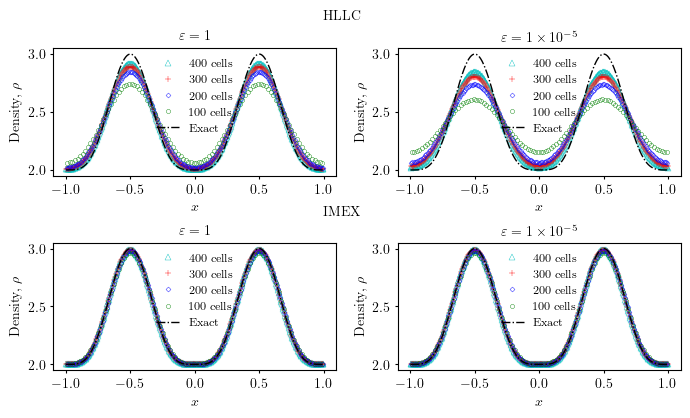

In [27]:
DIRECTORIES = ["build/Exec/SinProblem/output/HLLC/eps1/*",
               "build/Exec/SinProblem/output/HLLC/eps1e-5/*",
               "build/Exec/SinProblem/output/PEEK-SP111/eps1/*",
               "build/Exec/SinProblem/output/PEEK-SP111/eps1e-5/*"]

EPSILONS = [1, 1e-5]

exact_fmt = "k-."
res_fmts = ["go", "bD", "r+", "c^", "yD", "ms"]
marker_sizes = [3, 2.5, 4, 4, 4, 4]

fig, ax = plt.subplots(2, 2, figsize=(7,4))

for i in range(len(DIRECTORIES)):
    TESTCASE = DIRECTORIES[i]
    SUBRUN_DIRS = sorted(glob.glob(TESTCASE))
    if (len(SUBRUN_DIRS) == 0):
        print (f"Cannot find results with pattern {DIRECTORIES[i]}")
        continue
    SUBRUN_FINAL_OUTPUTS = [sorted(glob.glob(SUBRUN_DIR+"/plt[!E]*"))[-1] for SUBRUN_DIR in SUBRUN_DIRS]
    EXACT_SOLUTION = SUBRUN_DIRS[0] + "/pltEXACT_SOLN"
    adiabatic = 1.4
    epsilon = EPSILONS[i % 2]
    dim = 1
    rot = 0

    # plot numerical solution
    for ifile, plotfile in reversed(list(enumerate(SUBRUN_FINAL_OUTPUTS))):
        ds = yt.load(plotfile)
        label = f"{ds.domain_dimensions[0]} cells"

        # ray
        ray = get_ray(adiabatic, epsilon, rot, dim, ds)
        # plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
        ax[i // 2, i % 2].plot(ray["x"], ray["density"],res_fmts[ifile],label=label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)

    label = "Exact"
    ds = yt.load(EXACT_SOLUTION)
    exact_ray = get_ray(adiabatic, epsilon, 0, 1, ds)
    # plot_four(exact_ray,ax,exact_fmt,label)
    ax[i // 2, i % 2].plot(exact_ray["x"], exact_ray["density"],exact_fmt,label=label)

    # make plots pretty
    ax[i // 2, i % 2].set_xlabel("$x$")
    ax[i // 2, i % 2].set_ylabel("Density, $\\rho$")
    ax[i // 2, i % 2].legend()

    ax[i // 2, i % 2].set_title(r"$\varepsilon = 1$" if i % 2 == 0 else r"$\varepsilon = 1 \times 10^{-5}$")

# names_ys = [1, 0.8, 0.602, 0.405, 0.205]
# for i in range(len(NAMES)):
#     fig.text(0.5, names_ys[i], NAMES[i], horizontalalignment="center")
fig.text(0.5,  1,    "HLLC", horizontalalignment="center")
fig.text(0.5,  0.51, "IMEX", horizontalalignment="center")

fig.tight_layout(pad=0.8)
# fig.savefig(f"outputs/sin_problem.pdf", bbox_inches="tight")

fig.show()

## Isentropic vortex

In [95]:
DIRECTORIES = ["./build/Exec/IsentropicVortex/output/2d/*", "./build/Exec/IsentropicVortex/output/3d/*"]

for dir in DIRECTORIES:
    df = get_convergence_properties(dir, 1.4)
    print(df)

Cannot find results with pattern ./build/Exec/IsentropicVortex/output/2d/*
None
Cannot find results with pattern ./build/Exec/IsentropicVortex/output/3d/*
None


## GPU/CPU comparison

In [6]:
"""
Parameters
----------
test_dir : test case directory with a glob, for instance \"./build/Exec/IsentropicVortex/output/2d/*\"
    where inside that directory is subdirectories \"100\", \"200\", etc
"""
def compare_tests(testdir1, testdir2, adiabatic):
    SUBRUN_DIRS1 = sorted(glob.glob(testdir1))
    if (len(SUBRUN_DIRS1) == 0):
        print (f"Cannot find results with pattern {testdir1}")
        return
    SUBRUN_FINAL_OUTPUTS1 = [sorted(glob.glob(SUBRUN_DIR1+"/plt?????"))[-1] for SUBRUN_DIR1 in SUBRUN_DIRS1]
    SUBRUN_DIRS2 = sorted(glob.glob(testdir2))
    if (len(SUBRUN_DIRS2) == 0):
        print (f"Cannot find results with pattern {testdir2}")
        return
    SUBRUN_FINAL_OUTPUTS2 = [sorted(glob.glob(SUBRUN_DIR2+"/plt?????"))[-1] for SUBRUN_DIR2 in SUBRUN_DIRS2]
    error_norms = []
    for i in range(len(SUBRUN_FINAL_OUTPUTS1)):
        error_norms.append(compute_error_norms(SUBRUN_FINAL_OUTPUTS1[i], SUBRUN_FINAL_OUTPUTS2[i], adiabatic))
    df = pd.DataFrame(columns=["dx", "density L1", "density L2", "density Linf",
                               "u L1", "u L2", "u Linf", "v L1", "v L2", "v Linf",
                               "w L1", "w L2", "w Linf", "pressure L1", "pressure L2",
                               "pressure Linf"], data=error_norms)
    print(df)

compare_tests("build/Exec/RiemannProblem/output/test1/*", "build_gpu/Exec/RiemannProblem/output/test1/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test2/*", "build_gpu/Exec/RiemannProblem/output/test2/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test3/*", "build_gpu/Exec/RiemannProblem/output/test3/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test4/*", "build_gpu/Exec/RiemannProblem/output/test4/*", 1.4)
# compare_tests("build/Exec/RiemannProblem/output/test5/*", "build_gpu/Exec/RiemannProblem/output/test5/*", 1.4)
compare_tests("build/Exec/IsentropicVortex/output/2d/*", "build_gpu/Exec/IsentropicVortex/output/2d/*", 1.4)

Cannot find results with pattern build_gpu/Exec/RiemannProblem/output/test1/*


AssertionError: 

## Temporary code

In [17]:
BASE_FILENAMES = ["./build/Exec/RiemannProblem/output/test1/100/plt",
             "./build/Exec/RiemannProblem/output/test2/100/plt",
             "./build/Exec/RiemannProblem/output/test3/100/plt",
             "./build/Exec/RiemannProblem/output/test4/100/plt",
             "./build/Exec/RiemannProblem/output/test5/100/plt",
             "./build/Exec/SinProblem/output/128/plt",
             "./build/Exec/RiemannProblem/output/lax/400/plt",
             "./build/Exec/RiemannProblem/output/PEEK-SP111/bctest/0100/plt"]
FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

/tmp/ipykernel_23018/3611009491.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


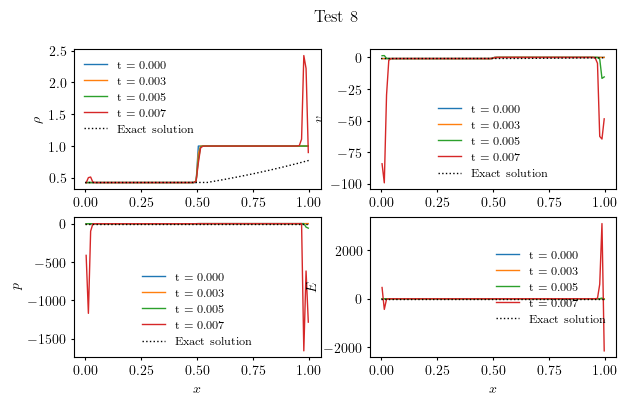

In [18]:
yt.set_log_level("error")
DIM = 1
# to_plot = [0,1,2,3,4]
to_plot = [7]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(7,4))
    for ds in ts:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = ""
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")
    # fig.savefig(f"outputs/{i+1}.svg")
    fig.show()

## Cylindrical Explosion

/tmp/ipykernel_21379/648381014.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


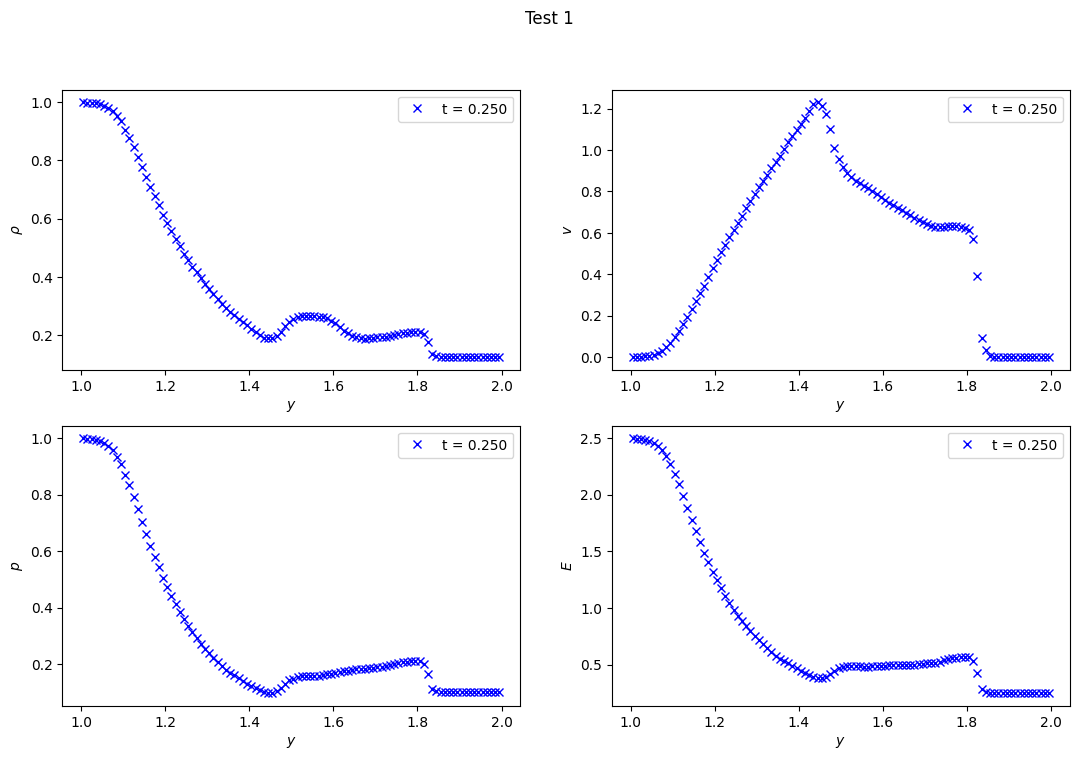

In [25]:
# BASE_FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt"]
# FILENAMES = [filename + "?????" for filename in BASE_FILENAMES]
FILENAMES = ["./outputs/cylindricalexplosion_200_3d/plt00065"]
# EXACT_SOLN_FILENAMES = [filename + "EXACT_SOLN" for filename in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 2
to_plot = [0]
for i in to_plot:
    FILENAME = FILENAMES[i]
    ts = yt.load(FILENAME)

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    # for ds in ts[-2:-1]:
    for ds in [ts]:
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            y_centre = (ds.domain_left_edge[1].value + ds.domain_right_edge[1].value)/2
            z_centre = (ds.domain_left_edge[2].value + ds.domain_right_edge[2].value)/2
            ray = ds.ray([x_centre,y_centre,z_centre], [x_centre,ds.domain_right_edge[1].value,z_centre])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        time_label = f"t = {ds.current_time.value:.3f}"
        # time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        # num_fmt = "bx"
        num_fmt = "bx"
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    # #
    # # Plot exact solution
    # #
    # exact = yt.load(EXACT_SOLN_FILENAMES[i])
    # ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    # mom = np.array(ray["mom_x"])
    # x = np.array(ray["x"])
    # density = np.array(ray["density"])
    # energy = np.array(ray["energy"])
    # vel_x = mom / density
    # pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    # exact_label = "Exact solution"
    # exact_fmt = "k:"

    # ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    # ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    # ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    # ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

# Plotting existing results

/tmp/ipykernel_21379/4294276362.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


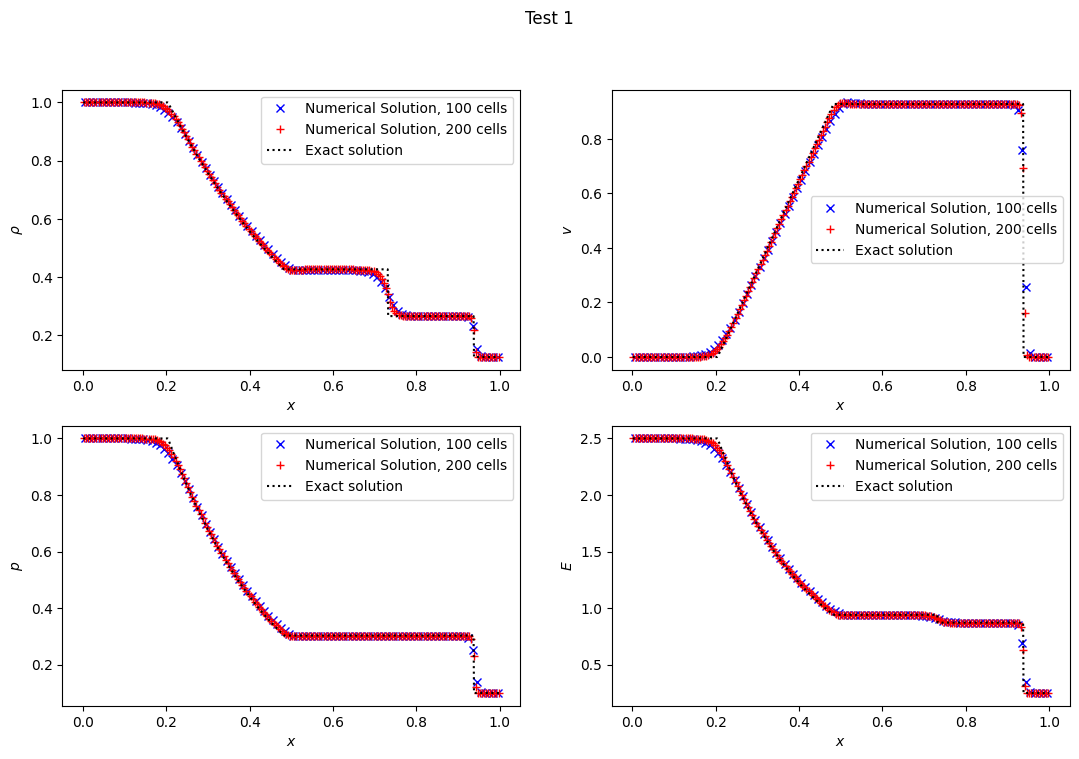

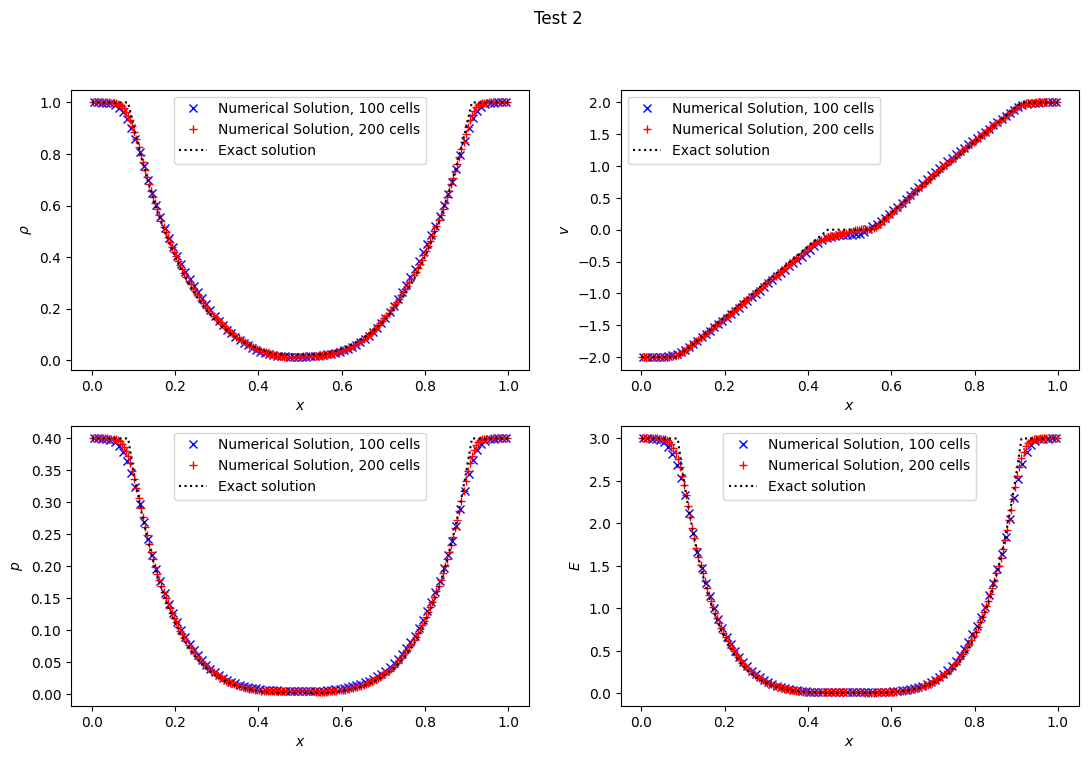

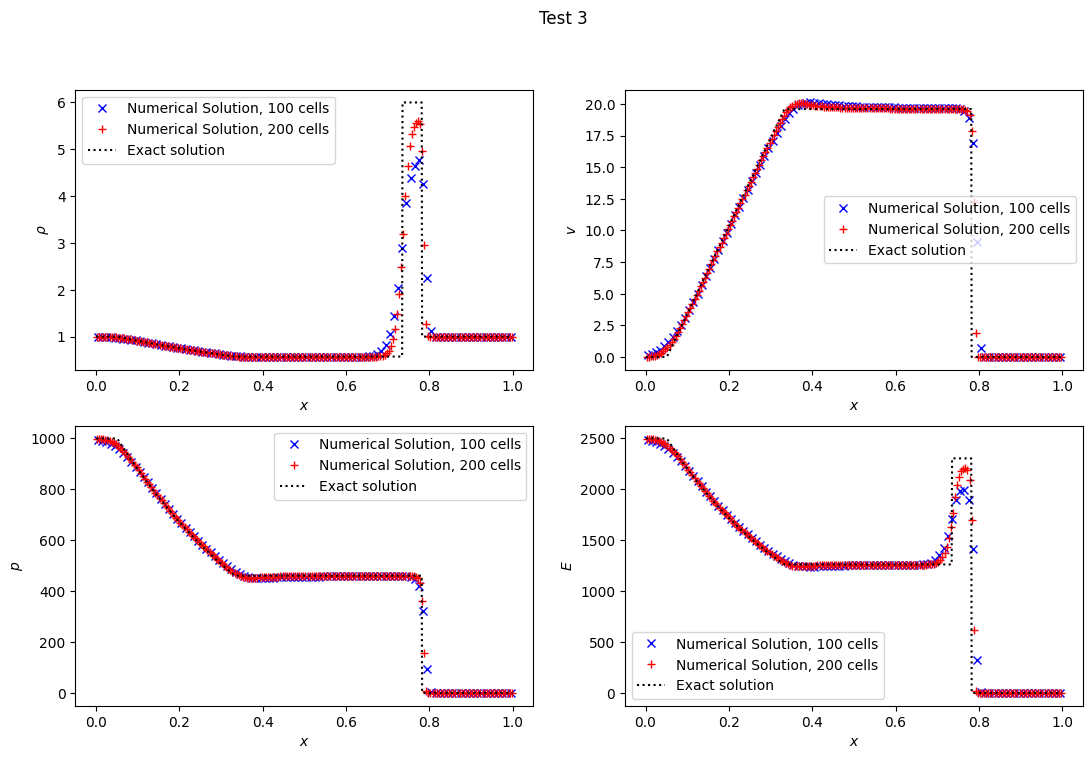

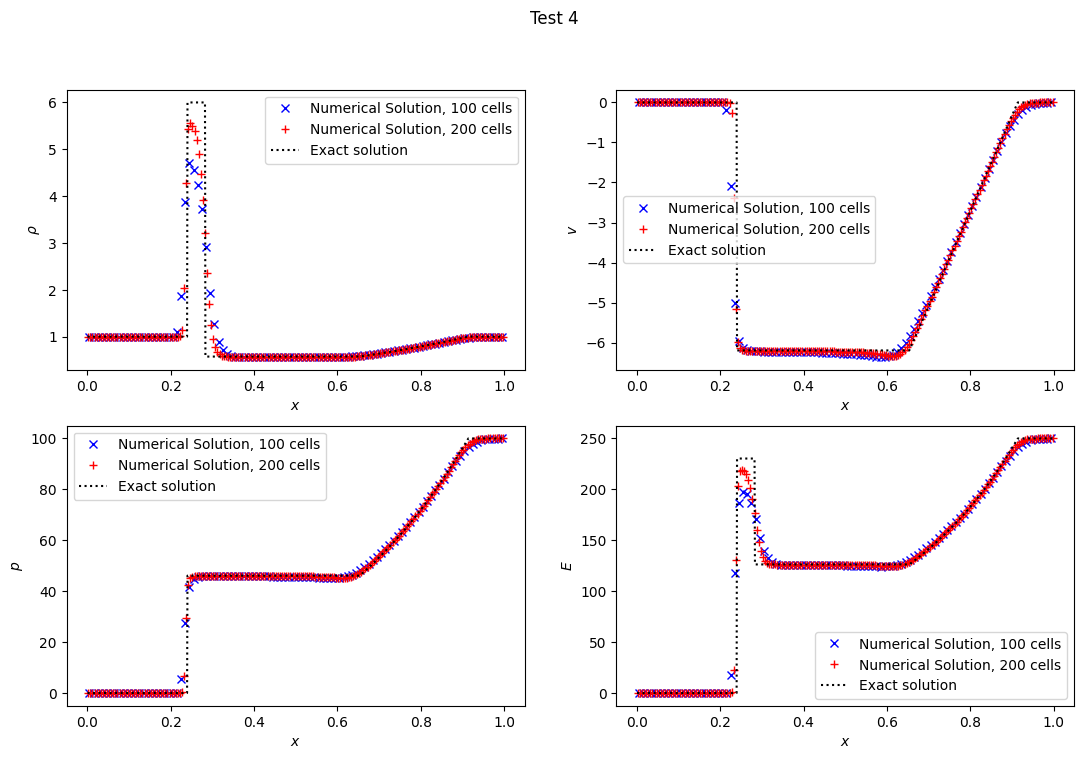

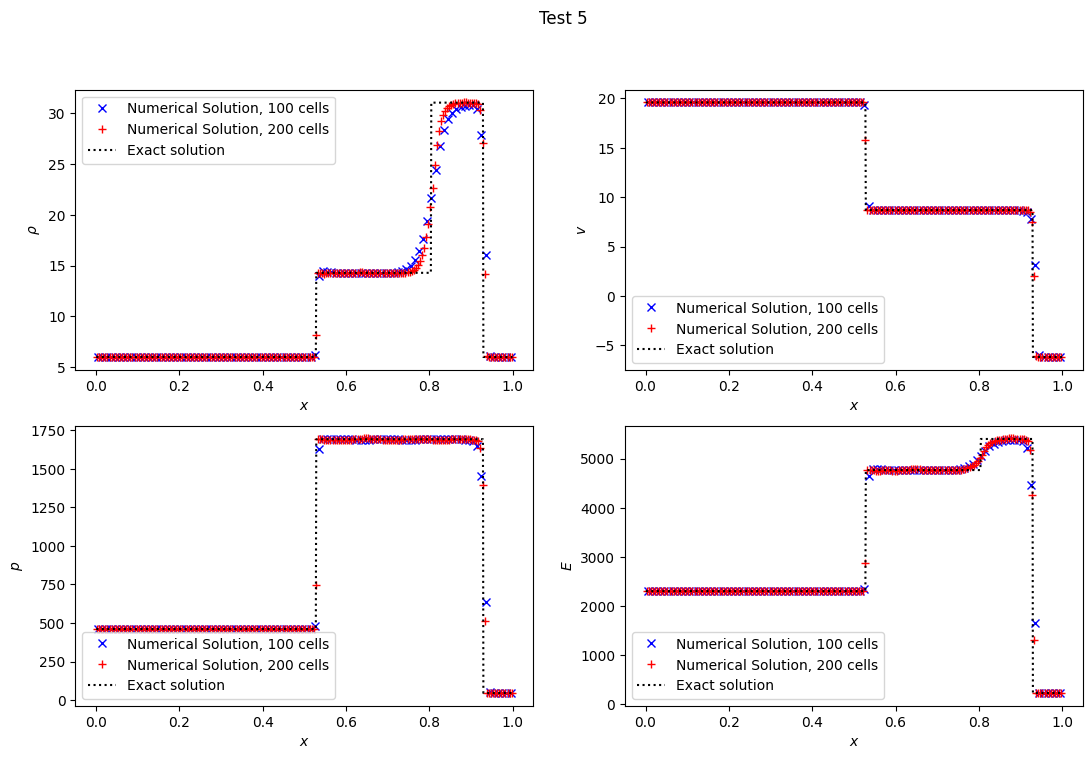

In [16]:
BASE_FILENAMES = [["./outputs/toro/muscl_hancock_100/test1/plt", "./outputs/toro/muscl_hancock_200/test1/plt"],
                  ["./outputs/toro/muscl_hancock_100/test2/plt", "./outputs/toro/muscl_hancock_200/test2/plt"],
                  ["./outputs/toro/muscl_hancock_100/test3/plt", "./outputs/toro/muscl_hancock_200/test3/plt"],
                  ["./outputs/toro/muscl_hancock_100/test4/plt", "./outputs/toro/muscl_hancock_200/test4/plt"],
                  ["./outputs/toro/muscl_hancock_100/test5/plt", "./outputs/toro/muscl_hancock_200/test5/plt"]]
FILENAMES = [[filename + "?????" for filename in subcase] for subcase in BASE_FILENAMES]
EXACT_SOLN_FILENAMES = [subcase[0] + "EXACT_SOLN" for subcase in BASE_FILENAMES]

adiabatic = 1.4

yt.set_log_level("error")
DIM = 1
to_plot = [0,1,2,3,4]
num_fmts = ["bx", "r+"]
for i in to_plot:
    subcase = FILENAMES[i]
    last_timestep_cases = []
    for FILENAME in subcase:
        ts = yt.load(FILENAME)
        last_timestep_cases.append(ts[-1])

    fig,ax = plt.subplots(2,2, figsize=(13,8))
    for subcase_no, ds in enumerate(last_timestep_cases):
        if DIM == 1:
            ray = ds.ray([ds.domain_left_edge[0].value,0,0], [ds.domain_right_edge[0].value,0,0])
            mom = np.array(ray["mom_x"])
            x = np.array(ray["x"])
        else:
            x_centre = (ds.domain_left_edge[0].value + ds.domain_right_edge[0].value)/2
            ray = ds.ray([x_centre,ds.domain_left_edge[1].value,0], [x_centre,ds.domain_right_edge[1].value,0])
            mom = np.array(ray["mom_y"])
            x = np.array(ray["y"])
        # time_label = f"t = {ds.current_time.value:.3f}"
        time_label = f"Numerical Solution, {len(x)} cells"
        density = np.array(ray["density"])
        energy = np.array(ray["energy"])
        vel_x = mom / density
        pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
            
        # print(density)
        num_fmt = num_fmts[subcase_no]
        ax[0,0].plot(x,density,num_fmt,label=time_label)
        ax[0,1].plot(x,vel_x,num_fmt,label=time_label)
        ax[1,0].plot(x,pressure,num_fmt,label=time_label)
        ax[1,1].plot(x,energy,num_fmt,label=time_label)

    #
    # Plot exact solution
    #
    exact = yt.load(EXACT_SOLN_FILENAMES[i])
    ray = exact.ray([exact.domain_left_edge[0].value,0,0], [exact.domain_right_edge[0].value,0,0])
    mom = np.array(ray["mom_x"])
    x = np.array(ray["x"])
    density = np.array(ray["density"])
    energy = np.array(ray["energy"])
    vel_x = mom / density
    pressure = (adiabatic - 1)*(energy - 0.5*density*np.power(vel_x,2))
        
    exact_label = "Exact solution"
    exact_fmt = "k:"

    ax[0,0].plot(x,density,exact_fmt,label=exact_label)
    ax[0,1].plot(x,vel_x,exact_fmt,label=exact_label)
    ax[1,0].plot(x,pressure,exact_fmt,label=exact_label)
    ax[1,1].plot(x,energy,exact_fmt,label=exact_label)


    ax[0,0].set_ylabel("$\\rho$")
    ax[0,1].set_ylabel("$v$")
    ax[1,0].set_ylabel("$p$")
    ax[1,1].set_ylabel("$E$")

    if DIM == 1:
        x_label = "$x$"
    else:
        x_label = "$y$"

    ax[0,0].set_xlabel(x_label)
    ax[0,1].set_xlabel(x_label)
    ax[1,0].set_xlabel(x_label)
    ax[1,1].set_xlabel(x_label)

    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

    fig.suptitle(f"Test {i+1}")

    fig.show()

/tmp/ipykernel_20932/456028912.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_20932/456028912.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


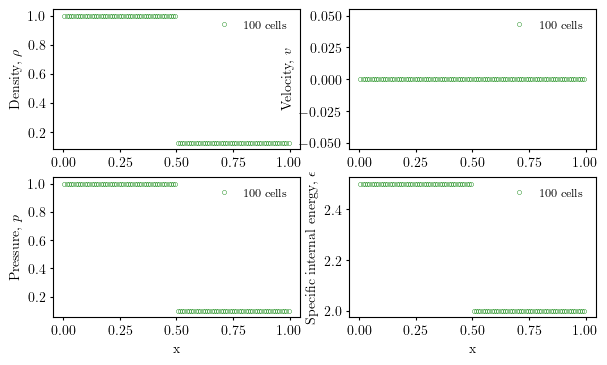

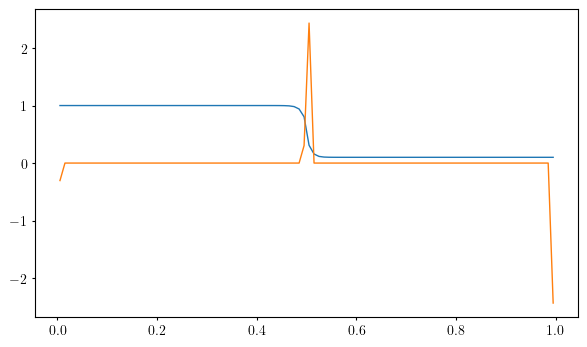

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(7,4))

# plot numerical solution
ds = yt.load("build/Exec/RiemannProblem/output/tmp/explicit")
label = f"{ds.domain_dimensions[0]} cells"

# ray
ray = get_ray(adiabatic, epsilon, rot, dim, ds)
plot_four(ray,ax,res_fmts[ifile],label,markersize = marker_sizes[ifile], fillstyle="none", markeredgewidth=0.3)
format_axes(ax, "x")

fig.show()

fig, ax = plt.subplots(1,1,figsize=(7,4))
ds = yt.load("build/Exec/RiemannProblem/output/tmp/pressure")
pray = ds.ray([0,0,0],[1,0,0])
ax.plot(pray["x"],pray["pressure"])

fig.show()

dt = 0.006761234038
dx = 1/100

outdens = ray["density"]
outmom = ray["mom_x"] - 0.5 * dt / dx * (np.roll(ray["pressure"],-1) - np.roll(ray["pressure"],1))

plt.plot(ray["x"],outmom/outdens)
plt.show()